In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import glob
import pandas as pd
from tqdm import tqdm
%matplotlib inline
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization
from keras.applications.vgg16 import VGG16

In [3]:
SIZE = 128

train_images = []
train_labels = []



In [4]:
#disease_types = ['COVID', 'non-COVID']
#train_dir = os.path.join('train_COVID/')
#train_data = []
#for label in (disease_types):
   #for file in os.listdir(os.path.join(train_dir, label)):
        #if str(file)[:5] == 'Covid':
            #id = 1
        #else: 
            #id = 0
        #train_data.append(file)
#train_data

In [4]:
disease_types = ['non-COVID', 'COVID']
train_dir = os.path.join('train_COVID/')
train_data = []
print(train_data)

for label, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), label, sp])
        
train = pd.DataFrame(train_data, columns = ['File', 'label', 'Disease Type'])
train

[]


,File,label,Disease Type
0,non-COVID/Non-Covid (1).png,0,non-COVID
1,non-COVID/Non-Covid (10).png,0,non-COVID
2,non-COVID/Non-Covid (100).png,0,non-COVID
3,non-COVID/Non-Covid (1000).png,0,non-COVID
4,non-COVID/Non-Covid (1001).png,0,non-COVID
...,...,...,...
2476,COVID/Covid (995).png,1,COVID
2477,COVID/Covid (996).png,1,COVID
2478,COVID/Covid (997).png,1,COVID
2479,COVID/Covid (998).png,1,COVID


In [5]:
seed = 42
train = train.sample(frac = 1, random_state=seed)
train.index = np.arange(len(train))
train.head()

,File,label,Disease Type
0,non-COVID/Non-Covid (1227).png,0,non-COVID
1,non-COVID/Non-Covid (451).png,0,non-COVID
2,COVID/Covid (322).png,1,COVID
3,COVID/Covid (379).png,1,COVID
4,non-COVID/Non-Covid (63).png,0,non-COVID


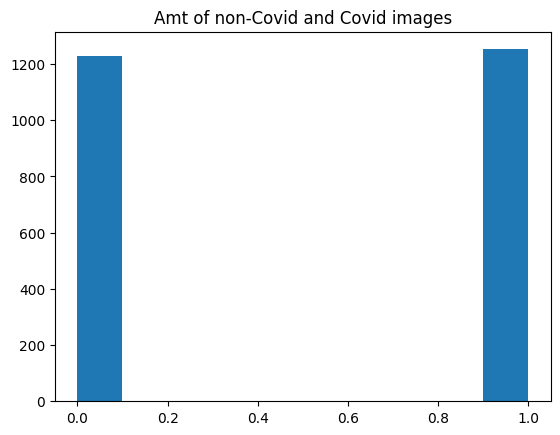

<Figure size 1000x1000 with 0 Axes>

In [6]:
plt.hist(train['label'])
plt.title('Amt of non-Covid and Covid images')
plt.figure(figsize = (10,10))
plt.show()

['non-COVID/Non-Covid (1227).png' 'non-COVID/Non-Covid (451).png'
 'non-COVID/Non-Covid (63).png' ... 'non-COVID/Non-Covid (879).png'
 'non-COVID/Non-Covid (91).png' 'non-COVID/Non-Covid (667).png']


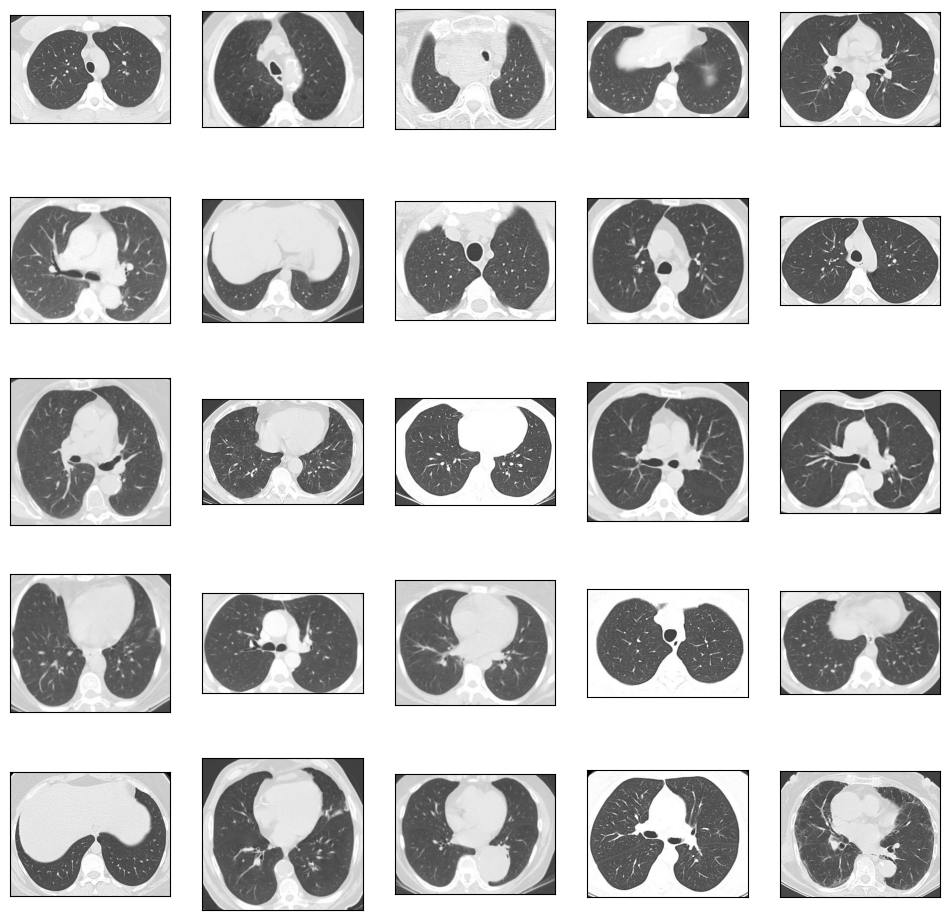

In [7]:
def display(label_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize = (12, 12))
    files = train['File'][train['Disease Type'] == label_types].values
    print(files)
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(train_dir, files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n = n + 1
display('non-COVID', 5, 5)

Preprocessing and IMG Resizing

In [6]:
SIZE = 128
def read_image(filepath):
    return cv2.imread(os.path.join(train_dir, filepath))

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [7]:
X_train = np.zeros((train.shape[0], SIZE, SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None: 
        X_train[i] = resize_image(image, (SIZE, SIZE))
    
X_Train = X_train / 255
print('Train Shape: {}'.format(X_Train.shape))

0it [00:00, ?it/s]

2481it [00:12, 194.04it/s]


Train Shape: (2481, 128, 128, 3)


In [8]:
Y_train = train['label'].values
Y_train = to_categorical(Y_train, num_classes = 2)


In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size = 0.2, random_state = seed)

In [11]:
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((1984, 128, 128, 3), (497, 128, 128, 3), (1984, 2), (497, 2))

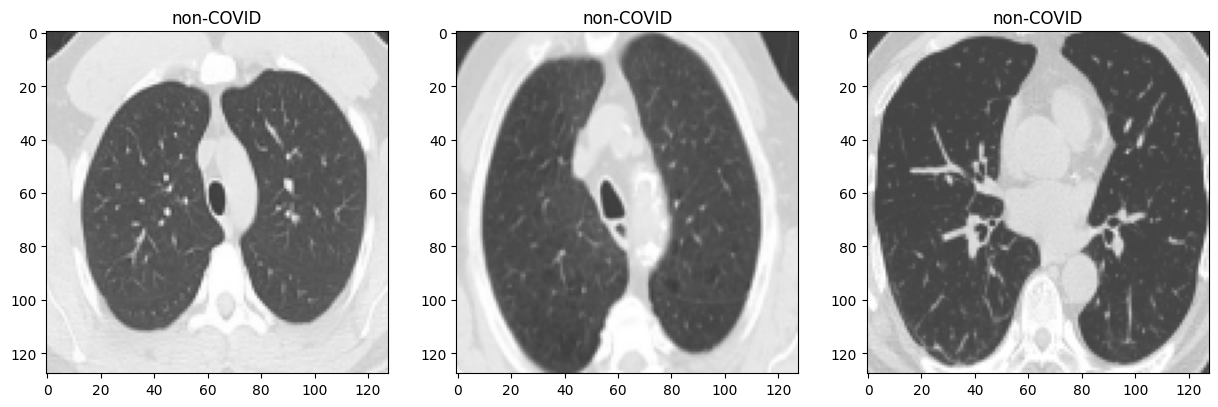

In [13]:
fig, ax = plt.subplots(1, 3, figsize = (15, 15))
for i in range(3):
    ax[i].imshow(X_Train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])


In [12]:
activation = 'sigmoid'
feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (128, 128, 3)))

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (128, 128, 3)))
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', input_shape = (128, 128, 3)))

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', input_shape = (128, 128, 3)))
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', input_shape = (128, 128, 3)))

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', input_shape = (128, 128, 3)))
feature_extractor.add(MaxPooling2D())

In [13]:
feature_extractor.add(Flatten())

##BREAK FOR TRANSFER LEARNING HERE, THIS IS PURE CNN PREDICTIONS

In [96]:
x = feature_extractor.output
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(2, activation = 'sigmoid')(x)

In [97]:
cnn = Model(inputs = feature_extractor.input, outputs = prediction_layer)
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
print(cnn.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24_input (InputLaye  [(None, 128, 128, 3)]     0         
 r)                                                              
                                                                 
 conv2d_24 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 conv2d_25 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 64)        3692

In [60]:
epochs = 25

In [ ]:
history = cnn.fit(X_train, Y_train, epochs = epochs, validation_data = (X_val, Y_val))

<function matplotlib.pyplot.show(close=None, block=None)>

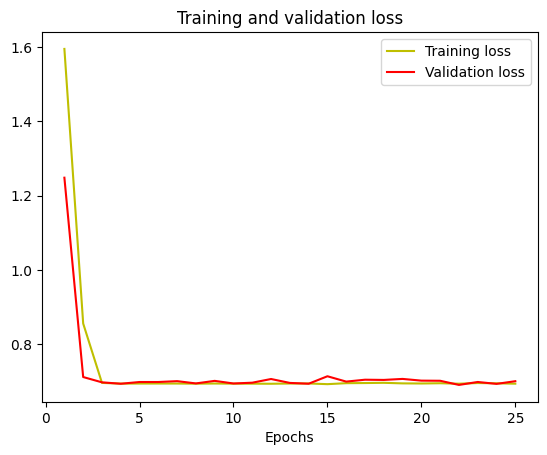

In [65]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.legend()
plt.show

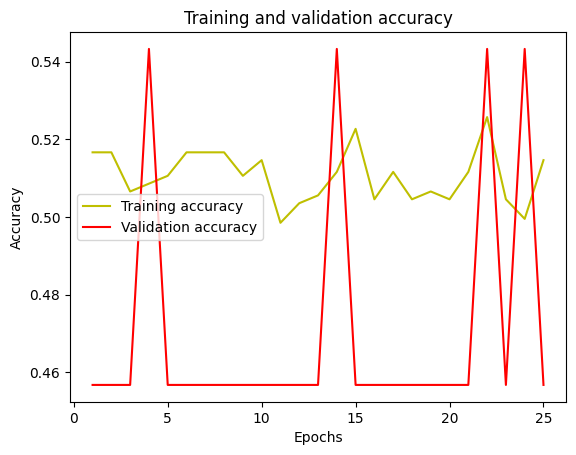

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [71]:
prediction_NN = cnn.predict(X_val)

16/16 [==============================] - 3s 182ms/step


###RANDOM FOREST CLASSIFICATION

In [18]:
X_for_RF = feature_extractor.predict(X_train)

from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators=1000, random_state = 42)

62/62 [==============================] - 12s 193ms/step


In [19]:
RF_model.fit(X_for_RF, Y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [20]:
X_test_feature = feature_extractor.predict(X_val)
prediction_RF = RF_model.predict(X_test_feature)

16/16 [==============================] - 3s 190ms/step


In [21]:
from sklearn import metrics
print("Accuracy = ", metrics.accuracy_score(Y_val, prediction_RF))

Accuracy =  0.8893360160965795


In [32]:
(prediction_RF.argmax(axis = 1))

array([0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,

In [34]:
Y_val.argmax(axis = 1)

array([0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,

In [36]:
labeled_prediction_RF = []
for label in (prediction_RF.argmax(axis = 1)):
    if label == 1:
        label = "COVID"
        labeled_prediction_RF.append(label)
    else: 
        label = "Non-Covid"
        labeled_prediction_RF.append(label)

labeled_Y_val = []
for label in (Y_val.argmax(axis = 1)):
    if label == 1:
        label = "COVID"
        labeled_Y_val.append(label)
    else: 
        label = "Non-Covid"
        labeled_Y_val.append(label)

In [38]:
labeled_prediction_RF

(['Non-Covid',
  'COVID',
  'COVID',
  'Non-Covid',
  'Non-Covid',
  'Non-Covid',
  'Non-Covid',
  'COVID',
  'COVID',
  'Non-Covid',
  'Non-Covid',
  'COVID',
  'Non-Covid',
  'COVID',
  'Non-Covid',
  'COVID',
  'Non-Covid',
  'Non-Covid',
  'COVID',
  'Non-Covid',
  'Non-Covid',
  'Non-Covid',
  'COVID',
  'Non-Covid',
  'COVID',
  'Non-Covid',
  'COVID',
  'Non-Covid',
  'Non-Covid',
  'COVID',
  'Non-Covid',
  'COVID',
  'Non-Covid',
  'Non-Covid',
  'Non-Covid',
  'COVID',
  'COVID',
  'Non-Covid',
  'COVID',
  'Non-Covid',
  'COVID',
  'COVID',
  'COVID',
  'Non-Covid',
  'Non-Covid',
  'Non-Covid',
  'Non-Covid',
  'Non-Covid',
  'Non-Covid',
  'COVID',
  'Non-Covid',
  'Non-Covid',
  'Non-Covid',
  'COVID',
  'Non-Covid',
  'COVID',
  'Non-Covid',
  'Non-Covid',
  'Non-Covid',
  'Non-Covid',
  'COVID',
  'Non-Covid',
  'COVID',
  'Non-Covid',
  'COVID',
  'COVID',
  'Non-Covid',
  'COVID',
  'COVID',
  'Non-Covid',
  'Non-Covid',
  'COVID',
  'COVID',
  'Non-Covid',
  'Non-Cov

In [39]:
labeled_Y_val

['Non-Covid',
 'COVID',
 'COVID',
 'COVID',
 'Non-Covid',
 'Non-Covid',
 'Non-Covid',
 'COVID',
 'COVID',
 'Non-Covid',
 'Non-Covid',
 'COVID',
 'Non-Covid',
 'COVID',
 'Non-Covid',
 'COVID',
 'Non-Covid',
 'Non-Covid',
 'COVID',
 'Non-Covid',
 'COVID',
 'Non-Covid',
 'COVID',
 'Non-Covid',
 'COVID',
 'COVID',
 'COVID',
 'Non-Covid',
 'Non-Covid',
 'COVID',
 'COVID',
 'COVID',
 'COVID',
 'Non-Covid',
 'Non-Covid',
 'COVID',
 'COVID',
 'Non-Covid',
 'COVID',
 'Non-Covid',
 'COVID',
 'Non-Covid',
 'Non-Covid',
 'COVID',
 'Non-Covid',
 'Non-Covid',
 'Non-Covid',
 'Non-Covid',
 'Non-Covid',
 'Non-Covid',
 'Non-Covid',
 'Non-Covid',
 'Non-Covid',
 'COVID',
 'Non-Covid',
 'COVID',
 'Non-Covid',
 'Non-Covid',
 'COVID',
 'Non-Covid',
 'COVID',
 'Non-Covid',
 'COVID',
 'Non-Covid',
 'Non-Covid',
 'COVID',
 'COVID',
 'COVID',
 'COVID',
 'Non-Covid',
 'Non-Covid',
 'COVID',
 'COVID',
 'COVID',
 'Non-Covid',
 'COVID',
 'Non-Covid',
 'Non-Covid',
 'Non-Covid',
 'COVID',
 'COVID',
 'COVID',
 'Non-Co

Text(50.722222222222214, 0.5, 'Predicted label')

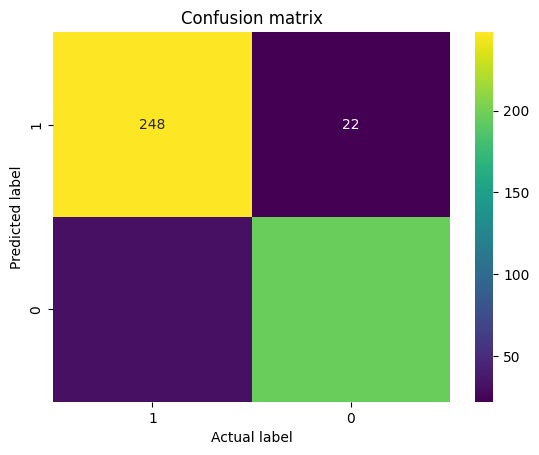

In [49]:
cm = confusion_matrix(Y_val.argmax(axis = 1), prediction_RF.argmax(axis = 1))
sns.heatmap(cm, annot=True, cmap = 'viridis', fmt = 'g')
plt.xticks([0.5,1.5],labels=[1,0])
plt.yticks([0.5,1.5],labels=[1,0])
plt.title('Confusion matrix')
plt.xlabel('Actual label')
plt.ylabel('Predicted label')